Model Building - Base Model

In [1]:
import pandas as pd
import joblib

import warnings

warnings.filterwarnings("ignore")

from afl_match_outcome_model.config import match_summary_file_path
from afl_match_outcome_model.data_preparation.match_summary_preprocessor import MatchSummaryPreprocessor

from afl_match_outcome_model.modelling_data_contract import ModellingDataContract
from afl_match_outcome_model.modelling.hyperparameter_tuning import (
    XGBHyperparameterTuner,
)
from afl_match_outcome_model.modelling.supermodel import SuperXGBClassifier
from afl_match_outcome_model.modelling.optuna_xgb_param_grid import OptunaXGBParamGrid

from afl_match_outcome_model.evaluation.model_evaluation import XGBClassifierEvaluator


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
RESPONSE = ModellingDataContract.RESPONSE

Load Data

In [4]:
data = pd.read_csv(match_summary_file_path)
data.tail()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season
4669,Melbourne,Carlton,9.17.71 - 11.7.73,-2,144,0.0,M.C.G.,Melbourne,2023-09-15 19:50:00,0,23.0,WINDY,2023,2023F2,2023F2_Melbourne_Carlton,2023.0
4670,Port Adelaide,Greater Western Sydney,9.16.70 - 13.15.93,-23,163,0.0,Adelaide Oval,Adelaide,2023-09-16 19:40:00,0,18.0,MOSTLY_SUNNY,2023,2023F2,2023F2_PortAdelaide_GreaterWesternSydney,2023.0
4671,Brisbane Lions,Carlton,11.13.79 - 9.9.63,16,142,1.0,Gabba,Brisbane,2023-09-23 17:15:00,0,23.0,MOSTLY_SUNNY,2023,2023F3,2023F3_BrisbaneLions_Carlton,2023.0
4672,Collingwood,Greater Western Sydney,8.10.58 - 8.9.57,1,115,1.0,M.C.G.,Melbourne,2023-09-22 19:50:00,0,16.0,MOSTLY_SUNNY,2023,2023F3,2023F3_Collingwood_GreaterWesternSydney,2023.0
4673,Collingwood,Brisbane Lions,12.18.90 - 13.8.86,4,176,1.0,M.C.G.,Melbourne,2023-09-29 14:30:00,0,29.0,SUNNY,2023,2023F4,2023F4_Collingwood_BrisbaneLions,2023.0


Preprocessing

In [5]:
match_preprocessor = MatchSummaryPreprocessor(
    categorical_features=['Venue', 'City', 'Opponent' ,'Team'],
    rolling_cols=['Team_Score', 'Opp_Score', 'Team_Goals', 'Opp_Goals'],
    rolling=[1, 3, 5, 10, 20],
    feature_list=['Home']
)
match_preprocessor.fit(data)
X, y = match_preprocessor.transform(data), match_preprocessor.get_response(data)
X.head()

,Home,Team_Score_rolling_1,Opp_Score_rolling_1,Team_Goals_rolling_1,Opp_Goals_rolling_1,Team_Score_rolling_3,Opp_Score_rolling_3,Team_Goals_rolling_3,Opp_Goals_rolling_3,Team_Score_rolling_5,Opp_Score_rolling_5,Team_Goals_rolling_5,Opp_Goals_rolling_5,Team_Score_rolling_10,Opp_Score_rolling_10,Team_Goals_rolling_10,Opp_Goals_rolling_10,Team_Score_rolling_20,Opp_Score_rolling_20,Team_Goals_rolling_20,Opp_Goals_rolling_20,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Blacktown,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Jiangwan Stadium,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Norwood Oval,Venue_Perth Stadium,Venue_Princes Park,Venue_Riverway Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_W.A.C.A.,Venue_Wellington,Venue_York Park,City_Adelaide,City_Alice Springs,City_Ballarat,City_Brisbane,City_Cairns,City_Canberra,City_Darwin,City_Geelong,City_Gold Coast,City_Hobart,City_Launceston,City_Melbourne,City_Perth,City_Shanghai,City_Sydney,City_Townsville,City_Wellington,Opponent_Adelaide,Opponent_Brisbane Lions,Opponent_Carlton,Opponent_Collingwood,Opponent_Essendon,Opponent_Fremantle,Opponent_Geelong,Opponent_Gold Coast,Opponent_Greater Western Sydney,Opponent_Hawthorn,Opponent_Melbourne,Opponent_North Melbourne,Opponent_Port Adelaide,Opponent_Richmond,Opponent_St Kilda,Opponent_Sydney,Opponent_West Coast,Opponent_Western Bulldogs,Team_Adelaide,Team_Brisbane Lions,Team_Carlton,Team_Collingwood,Team_Essendon,Team_Fremantle,Team_Geelong,Team_Gold Coast,Team_Greater Western Sydney,Team_Hawthorn,Team_Melbourne,Team_North Melbourne,Team_Port Adelaide,Team_Richmond,Team_St Kilda,Team_Sydney,Team_West Coast,Team_Western Bulldogs
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,92.0,103.0,13.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,100.0,111.0,14.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,73.0,187.0,10.0,29.0,88.333333,133.666667,12.333333,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,

In [6]:
y.value_counts(normalize=True)

Result
0    0.5
1    0.5
Name: proportion, dtype: float64

Train / Test Split

In [7]:
X.shape, y.shape

((9348, 100), (9348,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2407, stratify=y
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2407, stratify=y_train
)

In [9]:
y_train.value_counts(), y_test.value_counts(), y_cal.value_counts()

(Result
 1    2991
 0    2991
 Name: count, dtype: int64,
 Result
 0    935
 1    935
 Name: count, dtype: int64,
 Result
 0    748
 1    748
 Name: count, dtype: int64)

In [10]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True), y_cal.value_counts(normalize=True)

(Result
 1    0.5
 0    0.5
 Name: proportion, dtype: float64,
 Result
 0    0.5
 1    0.5
 Name: proportion, dtype: float64,
 Result
 0    0.5
 1    0.5
 Name: proportion, dtype: float64)

In [11]:
y.mean(), y_train.mean(), y_test.mean(), y_cal.mean()

(0.5, 0.5, 0.5, 0.5)

Optuna Hyperparameter Tuning Class - HyperParameterTuner & XGBHyperparameterTuner

In [13]:
xgb_tuner = XGBHyperparameterTuner(
    X_train, y_train, monotonicity_constraints={}
)

In [14]:
xgb_tuner.tune_hyperparameters()

[I 2024-01-12 21:01:19,963] A new study created in memory with name: no-name-a8a42f2e-c07b-4215-98ed-d5d7f31d681c
[I 2024-01-12 21:01:20,081] Trial 0 finished with value: 0.6552891244158189 and parameters: {'max_depth': 11, 'min_child_weight': 23, 'eta': 0.16106081261936636, 'gamma': 0.001348238532345051, 'lambda': 0.29936911785531517, 'alpha': 1.9655131955312617, 'subsample': 0.7137823614075274, 'colsample_bytree': 0.6531608872567125}. Best is trial 0 with value: 0.6552891244158189.
[I 2024-01-12 21:01:20,166] Trial 1 finished with value: 0.6814553823080636 and parameters: {'max_depth': 17, 'min_child_weight': 48, 'eta': 0.020637034914726193, 'gamma': 0.0033590309297413137, 'lambda': 2.2993148620498878, 'alpha': 5.347457436707654, 'subsample': 0.7512196947458718, 'colsample_bytree': 0.5104875090973724}. Best is trial 0 with value: 0.6552891244158189.
[I 2024-01-12 21:01:20,239] Trial 2 finished with value: 0.6769952137351735 and parameters: {'max_depth': 7, 'min_child_weight': 65, 'et

Number of finished trials:  100
Best trial:
  Value: 0.6396620435475503
  Params: 
    max_depth: 13
    min_child_weight: 32
    eta: 0.24079389902518583
    gamma: 0.0006238686039689188
    lambda: 0.08105864259161888
    alpha: 0.04217808800433789
    subsample: 0.8910129472308264
    colsample_bytree: 0.8388201062550849


In [15]:
params = xgb_tuner.get_best_params()
params

{'max_depth': 13,
 'min_child_weight': 32,
 'eta': 0.24079389902518583,
 'gamma': 0.0006238686039689188,
 'lambda': 0.08105864259161888,
 'alpha': 0.04217808800433789,
 'subsample': 0.8910129472308264,
 'colsample_bytree': 0.8388201062550849}

Training Model - SuperXGBClassifier class for training and predictions

In [16]:
params["objective"] = OptunaXGBParamGrid.error
params["num_rounds"] = 1000
params["early_stopping_rounds"] = 10
params["verbosity"] = 1
params["monotone_constraints"] = {}

In [17]:
super_xgb = SuperXGBClassifier(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_cal=X_cal,
    y_cal=y_cal,
    params=params,
)

In [18]:
super_xgb.fit()

[0]	validation_0-logloss:0.66985	validation_1-logloss:0.67465
[1]	validation_0-logloss:0.65519	validation_1-logloss:0.66218
[2]	validation_0-logloss:0.64442	validation_1-logloss:0.65500
[3]	validation_0-logloss:0.63535	validation_1-logloss:0.65062
[4]	validation_0-logloss:0.62615	validation_1-logloss:0.64412
[5]	validation_0-logloss:0.61778	validation_1-logloss:0.63958
[6]	validation_0-logloss:0.61242	validation_1-logloss:0.63795
[7]	validation_0-logloss:0.60570	validation_1-logloss:0.63323
[8]	validation_0-logloss:0.60001	validation_1-logloss:0.63178
[9]	validation_0-logloss:0.59596	validation_1-logloss:0.62916
[10]	validation_0-logloss:0.59232	validation_1-logloss:0.63093
[11]	validation_0-logloss:0.58780	validation_1-logloss:0.63048
[12]	validation_0-logloss:0.58380	validation_1-logloss:0.62965
[13]	validation_0-logloss:0.58039	validation_1-logloss:0.63039
[14]	validation_0-logloss:0.57621	validation_1-logloss:0.63055
[15]	validation_0-logloss:0.57156	validation_1-logloss:0.63122
[1

In [19]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8388201062550849, device=None,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0006238686039689188,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.24079389902518583,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=32, missing=nan, monotone_constraints={},
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
super_xgb.calibrate()

In [21]:
preds = super_xgb.predict(X)
train_preds = super_xgb.predict(X_train)
test_preds = super_xgb.predict(X_test)

In [22]:
probas = super_xgb.predict_proba(X)[:, 1]
train_probas = super_xgb.predict_proba(X_train)[:, 1]
test_probas = super_xgb.predict_proba(X_test)[:, 1]
cal_probas = super_xgb.predict_proba(X_cal)[:, 1]

In [23]:
cal_probas = super_xgb.predict_proba(X, calibrate=True)
train_cal_probas = super_xgb.predict_proba(X_train, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test, calibrate=True)
cal_cal_probas = super_xgb.predict_proba(X_cal, calibrate=True)

Check Average Predictions

In [24]:
y.mean(), probas.mean(), cal_probas.mean()

(0.5, 0.49960646, 0.4987323013608793)

In [25]:
y_train.mean(), train_probas.mean(), train_cal_probas.mean()

(0.5, 0.49899274, 0.4981759917730656)

In [26]:
y_test.mean(), test_probas.mean(), test_cal_probas.mean()

(0.5, 0.50051653, 0.49949828543636604)

In [27]:
y_cal.mean(), cal_probas.mean(), cal_cal_probas.mean()

(0.5, 0.4987323013608793, 0.49999931588838)

Model Evaluation

In [28]:
training_data = pd.concat([X_train, y_train], axis=1)
training_data["xgb_preds"] = train_preds
training_data["xgb_probas"] = train_probas
training_data["xgb_cal_probas"] = train_cal_probas
training_data['baseline'] = y_train.mean()
training_data['baseline_label'] = 1

train_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=training_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

In [29]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["xgb_preds"] = test_preds
test_data["xgb_probas"] = test_probas
test_data["xgb_cal_probas"] = test_cal_probas
test_data['baseline'] = y_train.mean()
test_data['baseline_label'] = 1

test_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

baseline_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="baseline",
    expected_label_name="baseline_label",
)


Model Averages

In [30]:
test_data[[RESPONSE, "xgb_probas", "xgb_cal_probas", "baseline_label", "baseline"]].describe()

,Result,xgb_probas,xgb_cal_probas,baseline_label,baseline
count,1870.000000,1870.000000,1870.000000,1870.0,1870.0
mean,0.500000,0.500517,0.499498,1.0,0.5
std,0.500134,0.154536,0.149693,0.0,0.0
min,0.000000,0.119978,0.117113,1.0,0.5
25%,0.000000,0.389742,0.394602,1.0,0.5
50%,0.500000,0.511071,0.512805,1.0,0.5
75%,1.000000,0.620788,0.616159,1.0,0.5
max,1.000000,0.833167,0.813180,1.0,0.5


Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [31]:
test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.6299
Compare Log-Loss: 	0.6931


(0.6299207273394251, 0.6299207273394251)

In [32]:
test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2202
Compare Brier Score: 	0.2500


(0.22020302387166177, 0.25)

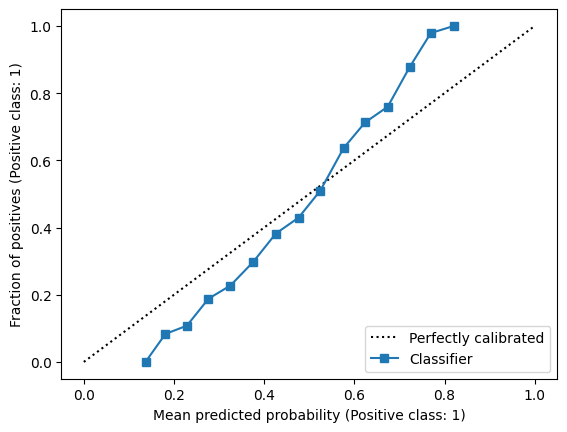

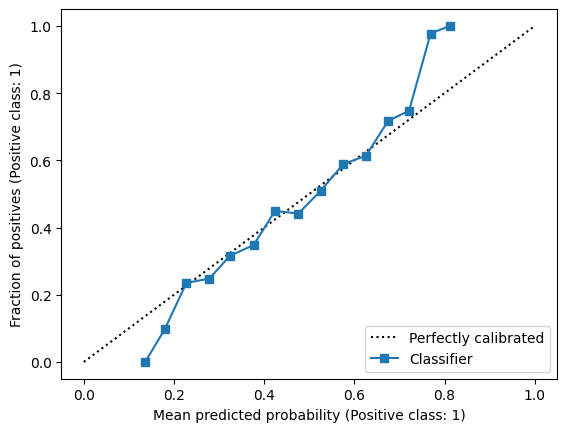

In [33]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [34]:
test_xgb_evals.get_accuracy(), test_xgb_evals.get_recall(), test_xgb_evals.get_precision(), test_xgb_evals.get_f1_score()

Expected Accuracy: 	0.6406
Compare Accuracy: 	0.5000
Expected Recall: 	0.6706
Compare Recall: 	1.0000
Expected Precision: 	0.6327
Compare Precision: 	0.5000
Expected F1 Score: 	0.6511
Compare F1 Score: 	0.6667


((0.6406417112299465, 0.5),
 (0.6705882352941176, 1.0),
 (0.6326942482341069, 0.5),
 (0.6510903426791277, 0.6666666666666666))

In [35]:
baseline_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

(array([[  0, 935],
        [  0, 935]]),
 array([[571, 364],
        [308, 627]]))

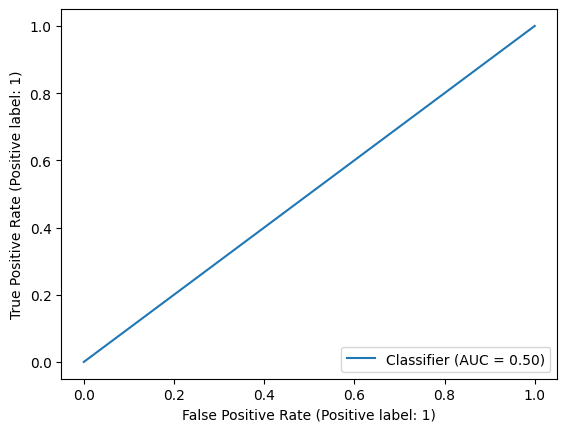

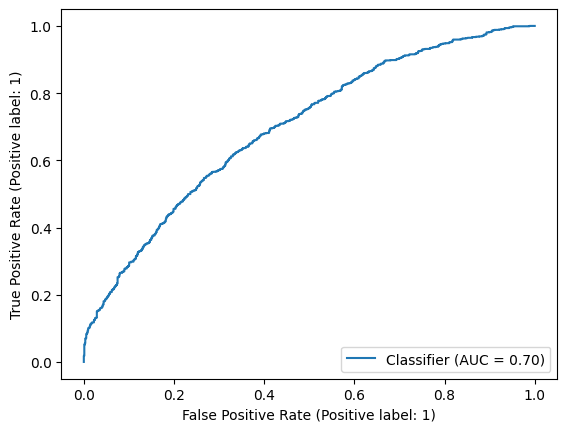

In [36]:
baseline_xgb_evals.plot_roc_curve()
test_xgb_evals.plot_roc_curve()

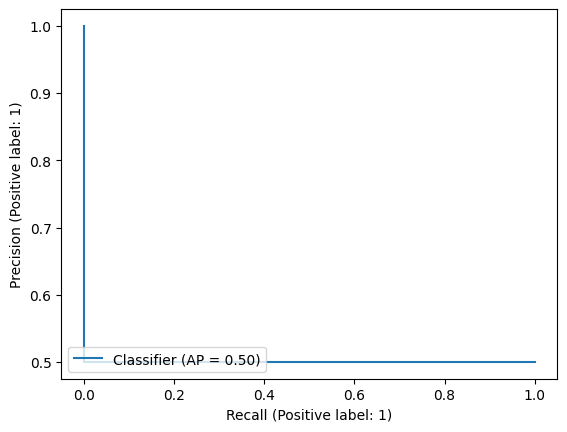

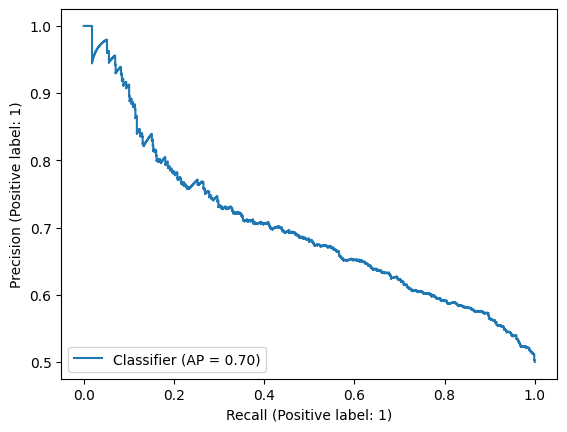

In [37]:
baseline_xgb_evals.plot_prauc_curve()
test_xgb_evals.plot_prauc_curve()

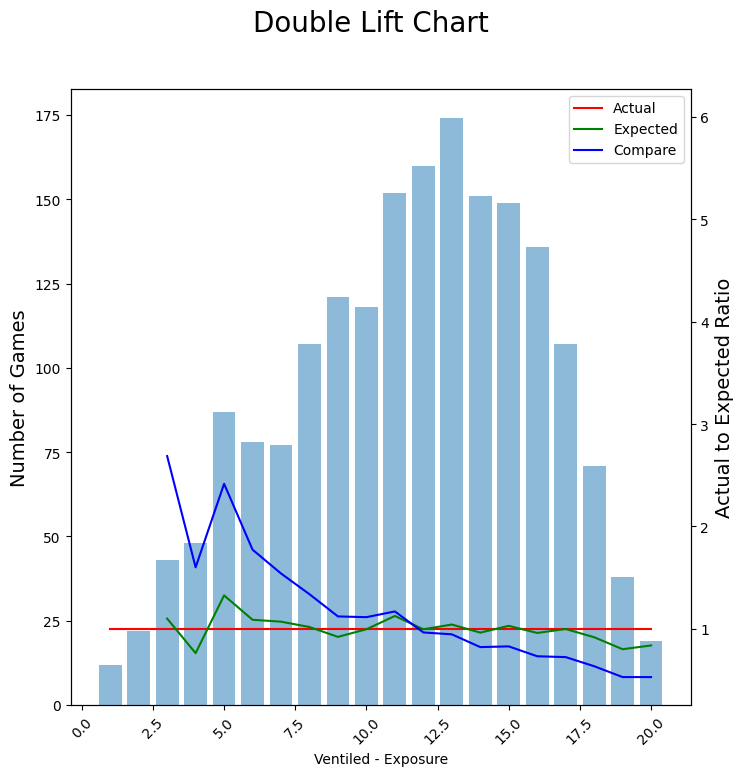

In [38]:
test_xgb_evals.plot_double_lift_chart()

Plots

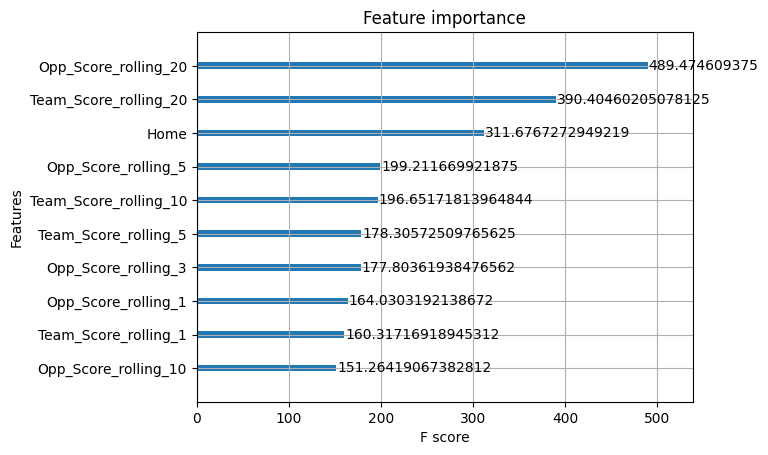

In [39]:
test_xgb_evals.plot_feature_importance(
    max_num_features=10, importance_type="total_gain"
)

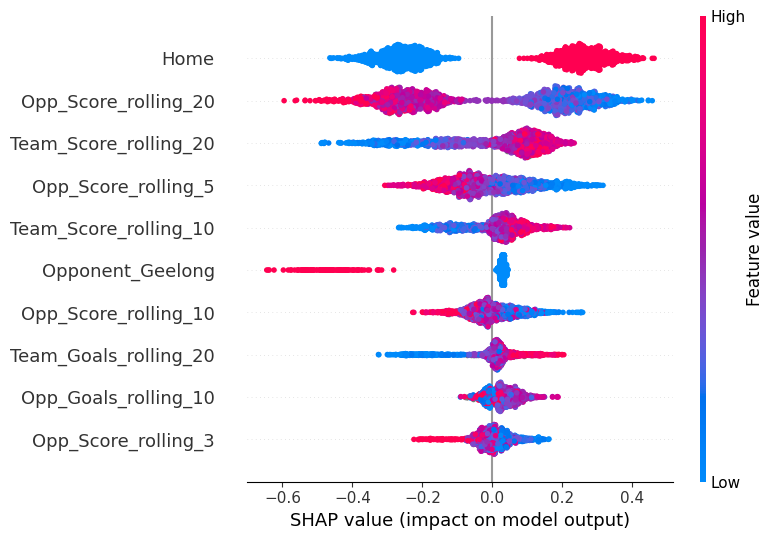

In [40]:
test_xgb_evals.plot_shap_summary_plot(sample=len(X_test))

In [41]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Home',
 'Opp_Score_rolling_20',
 'Team_Score_rolling_20',
 'Opp_Score_rolling_5',
 'Team_Score_rolling_10',
 'Opponent_Geelong',
 'Opp_Score_rolling_10',
 'Team_Goals_rolling_20',
 'Opp_Goals_rolling_10',
 'Opp_Score_rolling_3']

In [42]:
for col in top_10_features:
    # train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

In [ ]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

In [ ]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Export and Save Pipeline

In [ ]:
# pipeline = Pipeline([
#     ('preprocessor', preproc),
#     ('model', super_xgb)
# ])
# pipeline.predict_proba(data, calibrate=True).mean(), pipeline.predict_proba(data, calibrate=False).mean()

In [ ]:
# joblib.dump(pipeline, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/base_match_outcome_pipeline.joblib")